<a href="https://colab.research.google.com/github/monindew/Pytorch_Study/blob/main/20240819_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
train_rawdata = datasets.MNIST(root = "dataset",
                               train=True,
                               download=True,
                               transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root = "dataset",
                              train=False,
                              download=True,
                              transform=transforms.ToTensor())
print('number of training data : ', len(train_rawdata))
print('number of test data : ', len(test_dataset))

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 51840426.79it/s]


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 3665668.88it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 13509948.79it/s]


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 7712764.68it/s]


Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw

number of training data :  60000
number of test data :  10000


In [3]:
VALIDATION_RATE = 0.2
train_indices, val_indices, _, _ = train_test_split(range(len(train_rawdata)),
                                              train_rawdata.targets,
                                              stratify=train_rawdata.targets,
                                              test_size=VALIDATION_RATE)

In [4]:
train_dataset = Subset(train_rawdata, train_indices)
validation_dataset = Subset(train_rawdata, val_indices)

In [5]:
print(len(train_dataset), len(validation_dataset), len(test_dataset))

48000 12000 10000


In [6]:
BATCH_SIZE = 128

train_batches = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_batches = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_batches = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [7]:
X_train, y_train = next(iter(train_batches))
print(X_train.shape, y_train.shape)

torch.Size([128, 1, 28, 28]) torch.Size([128])


In [13]:
index = 1
X_train[index, :, :, :,].shape

torch.Size([1, 28, 28])

In [14]:
X_train[index, :, :, :].shape

torch.Size([1, 28, 28])

In [15]:
X_train[index, :, :, :].numpy().reshape(28, 28).shape

(28, 28)

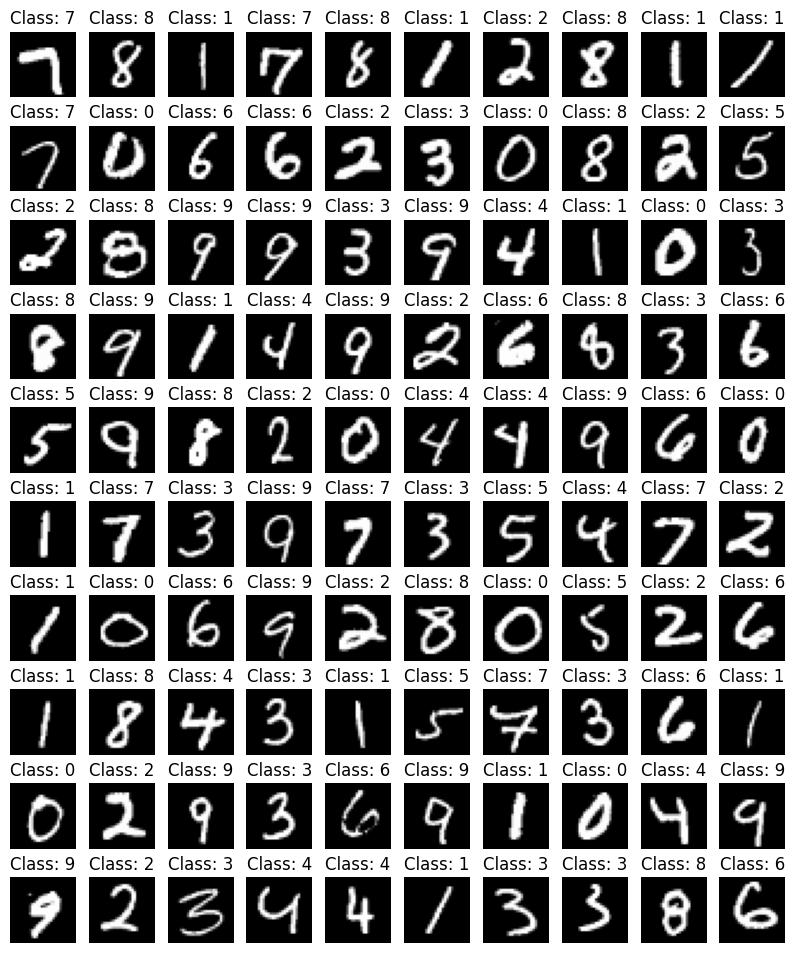

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 12))

for index in range(100):
  plt.subplot(10, 10, index+1)
  plt.axis("off")
  plt.imshow(X_train[index, :, :, :].numpy().reshape(28,28), cmap="gray")
  plt.title("Class: " + str(y_train[index].item()))

In [17]:
X_train, y_train = next(iter(train_batches))
print(X_train.shape, y_train.shape)
print(X_train.size(0))
print(X_train.view(X_train.size(0), -1).shape)

torch.Size([128, 1, 28, 28]) torch.Size([128])
128
torch.Size([128, 784])


In [18]:
class FunModel(nn.Module):
  def __init__(self,input_dim, output_dim):
    super().__init__()

    self.linear_layers = nn.Sequential(
        nn.Linear(input_dim, 256),
        nn.LeakyReLU(0.1),
        nn.Linear(256, 256),
        nn.LeakyReLU(0.1),
        nn.Linear(256, 128),
        nn.LeakyReLU(0.1),
        nn.Linear(128, output_dim),
        nn.LogSoftmax(dim=-1)
    )

  def forward(self, x):
    y = self.linear_layers(x)
    return y

minibatch_size = 128
input_dim = 28 * 28
output_dim = 10
model = FunModel(input_dim, output_dim)

loss_func = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters())

In [19]:
from copy import deepcopy

In [20]:
def train_model(model, early_stop, n_epochs, progress_interval):
  train_losses, valid_losses, lowest_loss = list(), list(), np.inf

  for epoch in range(n_epochs):
    train_loss, valid_loss = 0, 0
    model.train()
    for x_minibatch, y_minibatch in train_batches:
      y_minibatch_pred = model(x_minibatch.view(x_minibatch.size(0), -1))
      loss = loss_func(y_minibatch_pred, y_minibatch)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      train_loss += loss.item()

    train_loss = train_loss / len(train_batches)
    train_losses.append(train_loss)

    model.eval()
    with torch.no_grad():
      for x_minibatch, y_minibatch in val_batches:
        y_minibatch_pred = model(x_minibatch.view(x_minibatch.size(0), -1))
        loss = loss_func(y_minibatch_pred, y_minibatch)
        valid_loss += loss.item()

    valid_loss = valid_loss / len(val_batches)
    valid_losses.append(valid_loss)

    if valid_losses[-1] < lowest_loss:
      lowest_loss = valid_losses[-1]
      lowest_epoch = epoch
      best_model = deepcopy(model.state_dict())
    else:
      if (early_stop > 0) and lowest_epoch + early_stop < epoch:
        print ("Early Stopped", epoch, "epochs")
        break

    if (epoch % progress_interval) == 0:
      print(train_losses[-1], valid_losses[-1], lowest_loss, lowest_epoch, epoch)

  model.load_state_dict(best_model)
  return model, lowest_loss, train_losses, valid_losses

In [21]:
nb_epochs = 10
progress_interval = 3
early_stop = 5

model, lowest_loss, train_losses, valid_losses = train_model(model, early_stop, nb_epochs, progress_interval)

0.37551944714784624 0.21646400715442413 0.21646400715442413 0 0
0.06851986034959555 0.10397450929071675 0.10397450929071675 3 3
0.03258904732577503 0.11083706978589614 0.0943558345786593 4 6
0.016953043643540392 0.12755719766496343 0.0943558345786593 4 9


In [24]:
print(torch.ne(torch.tensor([[1,3], [2,5]]), torch.tensor([[1, 2], [2, 3]])))
print(torch.equal(torch.tensor([[1, 3], [2, 5]]), torch.tensor([[1, 3], [2, 5]])))

tensor([[False,  True],
        [False,  True]])
True


In [26]:
x_minibatch, y_minibatch = next(iter(test_batches))
y_test_pred = model(x_minibatch.view(x_minibatch.size(0), -1))
pred = torch.argmax(y_test_pred, dim=1)
print(y_test_pred.shape, y_minibatch.shape, pred.shape)
correct = pred.eq(y_minibatch).sum()
print(pred.eq(y_minibatch).sum(), pred.eq(y_minibatch).sum().item())

torch.Size([128, 10]) torch.Size([128]) torch.Size([128])
tensor(126) 126


In [28]:
torch.tensor([[0.6, 0.0, 0.0, 0.0],
              [0.0, 0.4, 0.0, 0.0],
              [0.0, 0.0, 1.2, 0.0],
              [0.0, 0.0, 0.0, -0.4]]).nonzero()

tensor([[0, 0],
        [1, 1],
        [2, 2],
        [3, 3]])

In [29]:
torch.tensor([1, 1, 1, 0, 1]).nonzero()

tensor([[0],
        [1],
        [2],
        [4]])

In [30]:
data = torch.FloatTensor([ [1, 2], [3, 4] ])
print(data.shape, data[:, 0])

torch.Size([2, 2]) tensor([1., 3.])


In [31]:
len(test_batches.dataset)

10000

In [33]:
print(pred.ne(y_minibatch).shape, pred.ne(y_minibatch), pred.ne(y_minibatch).nonzero(), pred.ne(y_minibatch).nonzero()[:, 0], pred.ne(y_minibatch).nonzero()[:, 0].numpy().tolist())

torch.Size([128]) tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
        False, False, False, False, False,  True, False, False, False, False,
        False, False, False, False, False, Fal

In [34]:
wrong_idx = pred.ne(y_minibatch).nonzero()[:, 0].numpy().tolist()
for index in wrong_idx:
  print(index)

104
115


In [40]:
test_loss = 0
correct = 0
model.eval()

wrong_samples, wrong_preds, actual_preds = list(), list(), list()

model.eval()
with torch.no_grad():
  for x_minibatch, y_minibatch in test_batches:
    y_test_pred = model(x_minibatch.view(x_minibatch.size(0), -1))
    test_loss += loss_func(y_test_pred, y_minibatch)
    pred = torch.argmax(y_test_pred, dim=1)
    correct += pred.eq(y_minibatch).sum().item()

    wrong_idx = pred.ne(y_minibatch).nonzero()[:, 0].numpy().tolist()
    for index in wrong_idx:
      wrong_samples.append(x_minibatch[index])
      wrong_preds.append(pred[index])
      actual_preds.append(y_minibatch[index])

test_loss /= len(test_batches.dataset)
print("Average Test Loss: {:.4f}".format(test_loss))
print("Accuracy: {}/{} ({:.2f}%)".format(correct, len(test_batches.dataset), 100*correct / len(test_batches.dataset) ))

Average Test Loss: 0.0006
Accuracy: 9750/10000 (97.50%)


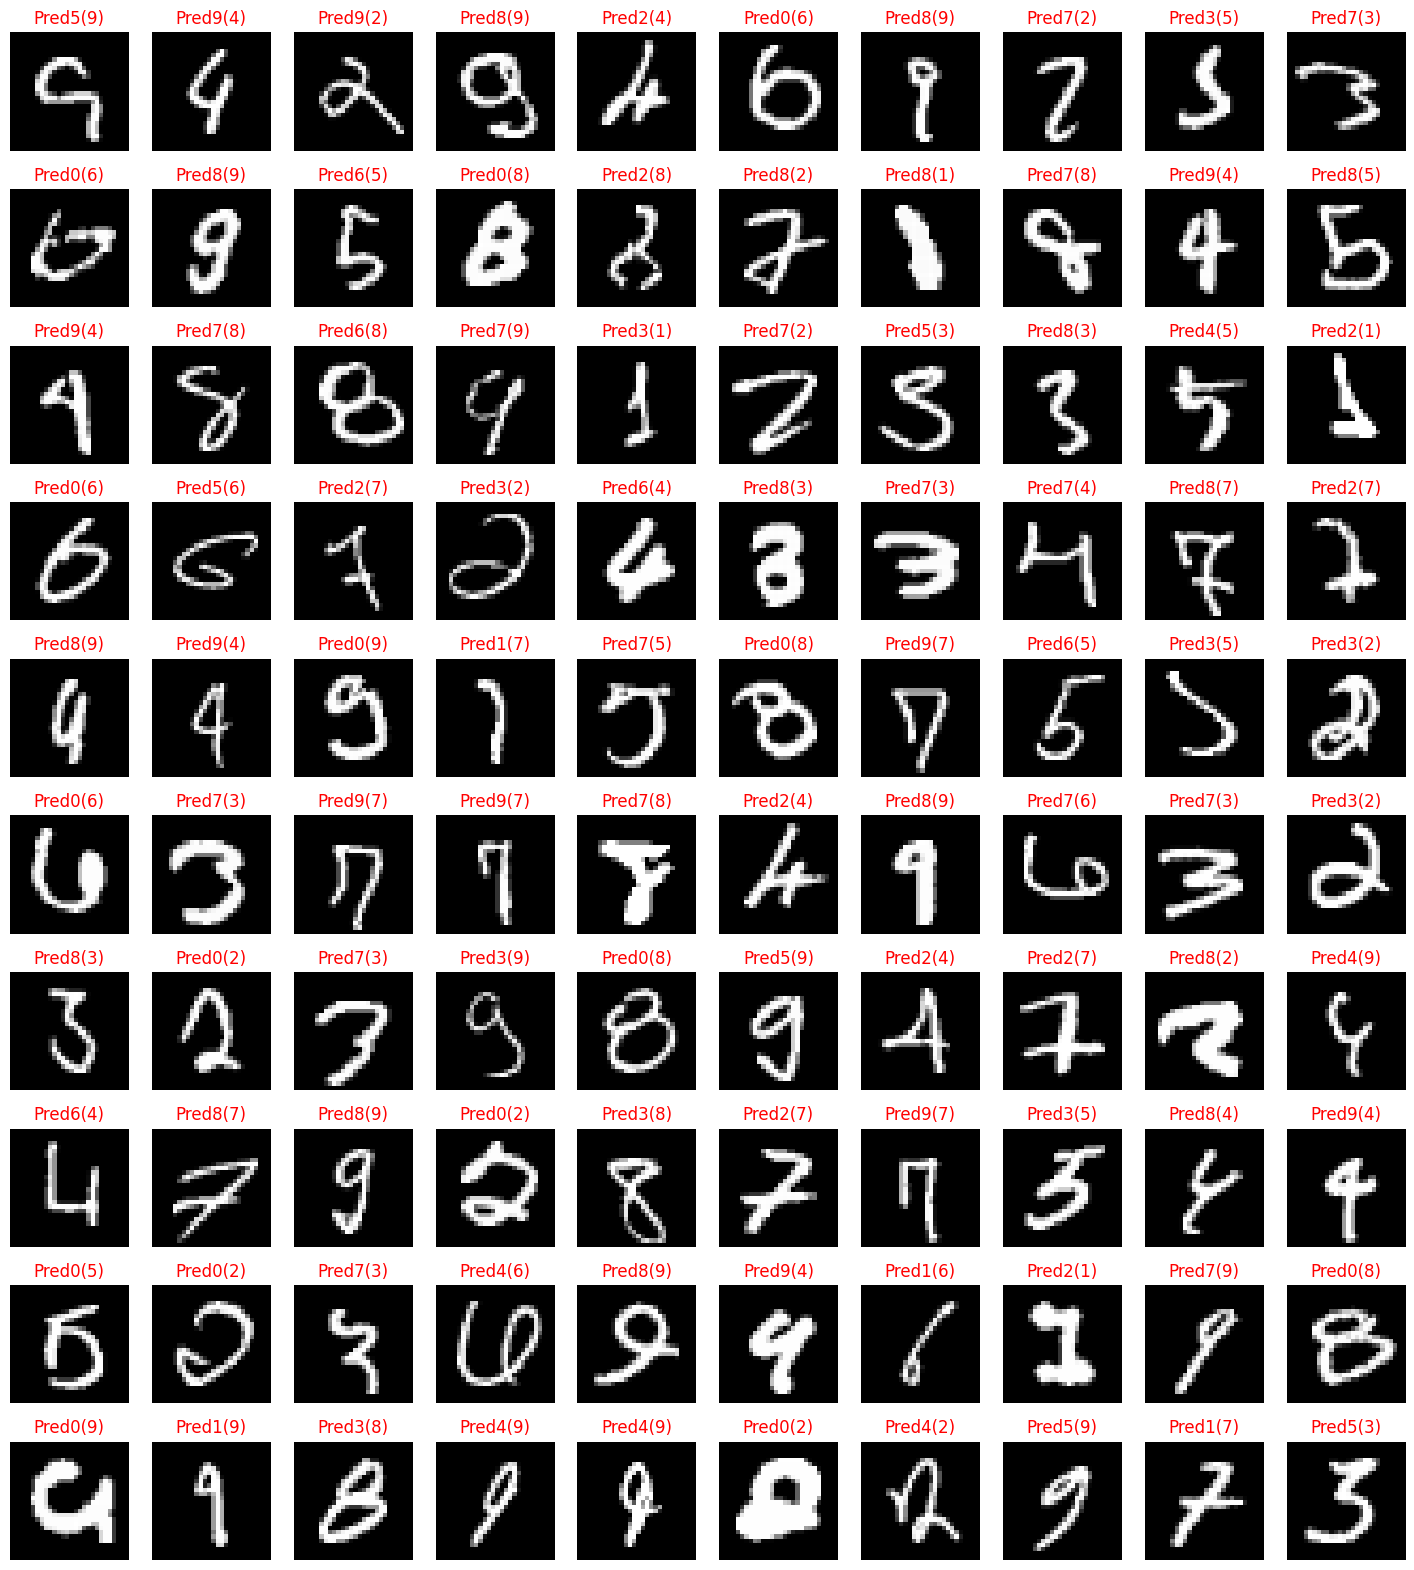

In [42]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(18, 20))

for index in range(100):
  plt.subplot(10, 10, index + 1)
  plt.axis("off")
  plt.imshow(wrong_samples[index].numpy().reshape(28, 28), cmap="gray")
  plt.title("Pred" + str(wrong_preds[index].item()) + "(" + str(actual_preds[index].item()) + ")", color="red")